### Import Libraries

In [1]:
import pandas as pd
import numpy as np

# Recommendation model that utilizes Matrix Factorization and Collaborative Filtering techniques.

**The process begins with data preparation, where necessary libraries and datasets are imported, and the movies and ratings datasets are merged based on the ‘movieId’ column. This is followed by data cleaning to drop unnecessary columns and handle missing values.**

**The model then transforms the data by creating a pivot table where each row represents a user and each column represents a movie, with the entries being the ratings that a user gives to a movie. The model applies Singular Value Decomposition (SVD) to this pivot table, a dimensionality reduction technique that factorizes the user-movie matrix into the product of two lower dimensionality orthogonal matrices and a diagonal matrix. This process captures the latent relationships between users and movies.**

**The model then computes the correlation coefficient for every pair of movies based on their latent features obtained from SVD, resulting in a similarity matrix where each entry represents the similarity between two movies. Given a movie, the model finds other movies with a high correlation coefficient in the similarity matrix and recommends these to the user.**

**This approach is a form of Collaborative Filtering as it uses the behavior of users (their ratings) to make recommendations. It’s also a form of Content-Based Filtering as it uses information about the items (movies) to make recommendations. The combination of these techniques allows the model to make accurate and personalized recommendations.**

### Import the movies dataset

In [2]:
movie_df = pd.read_csv('movies.csv')

In [3]:
rating_df = pd.read_csv('ratings.csv')

### Checking the tables

In [4]:
movie_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [5]:
rating_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


### Now combine the two tables and drop things we dont have to use

In [6]:
combine_movie_rating = pd.merge(rating_df, movie_df, on='movieId')
combine_movie_rating.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,18,1,3.5,1455209816,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6,19,1,4.0,965705637,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
7,21,1,3.5,1407618878,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
8,27,1,3.0,962685262,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
9,31,1,5.0,850466616,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [7]:
columns = ['timestamp', 'genres']
combine_movie_rating = combine_movie_rating.drop(columns, axis=1)
combine_movie_rating.head(10)

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)
5,18,1,3.5,Toy Story (1995)
6,19,1,4.0,Toy Story (1995)
7,21,1,3.5,Toy Story (1995)
8,27,1,3.0,Toy Story (1995)
9,31,1,5.0,Toy Story (1995)


In [8]:
combine_movie_rating = combine_movie_rating.dropna(axis = 0, subset = ['title'])

movie_ratingCount = (combine_movie_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movie_ratingCount.head(10)

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2
5,'Tis the Season for Love (2015),1
6,"'burbs, The (1989)",17
7,'night Mother (1986),1
8,(500) Days of Summer (2009),42
9,*batteries not included (1987),7


In [9]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
rating_with_totalRatingCount.head(10)

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215
5,18,1,3.5,Toy Story (1995),215
6,19,1,4.0,Toy Story (1995),215
7,21,1,3.5,Toy Story (1995),215
8,27,1,3.0,Toy Story (1995),215
9,31,1,5.0,Toy Story (1995),215


### Now drop the duplicate data

In [10]:
user_rating = rating_with_totalRatingCount.drop_duplicates(['userId','title'])
user_rating.head(10)

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215
5,18,1,3.5,Toy Story (1995),215
6,19,1,4.0,Toy Story (1995),215
7,21,1,3.5,Toy Story (1995),215
8,27,1,3.0,Toy Story (1995),215
9,31,1,5.0,Toy Story (1995),215


## Matrix Factorization

### Now create a matrix and fill 0 values  

In [11]:
movie_user_rating_pivot = user_rating.pivot(index = 'userId', columns = 'title', values = 'rating').fillna(0)
movie_user_rating_pivot.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
X = movie_user_rating_pivot.values.T
X.shape

(9719, 610)

### Now lets fit the model

In [13]:
import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(9719, 12)

In [14]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(9719, 9719)

### Now lets check the results

In [15]:
movie_title = movie_user_rating_pivot.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index("Guardians of the Galaxy (2014)")

In [16]:
# Calculate correlation coefficient
corr_coffey_hands  = corr[coffey_hands]
list(movie_title[(corr_coffey_hands >= 0.9)])

['Adjustment Bureau, The (2011)',
 'Amazing Spider-Man, The (2012)',
 'Ant-Man (2015)',
 'Avatar (2009)',
 'Avengers, The (2012)',
 'Avengers: Age of Ultron (2015)',
 'Big Hero 6 (2014)',
 'Brave (2012)',
 'Captain America: Civil War (2016)',
 'Captain America: The First Avenger (2011)',
 'Captain America: The Winter Soldier (2014)',
 'Cloud Atlas (2012)',
 'Cloudy with a Chance of Meatballs (2009)',
 'Dark Knight Rises, The (2012)',
 'Deadpool (2016)',
 'Despicable Me (2010)',
 'District 9 (2009)',
 'Django Unchained (2012)',
 'Doctor Strange (2016)',
 'Edge of Tomorrow (2014)',
 "Ender's Game (2013)",
 'Grand Budapest Hotel, The (2014)',
 'Gravity (2013)',
 'Guardians of the Galaxy (2014)',
 'Guardians of the Galaxy 2 (2017)',
 'Harry Potter and the Deathly Hallows: Part 1 (2010)',
 'Harry Potter and the Deathly Hallows: Part 2 (2011)',
 'Hobbit: An Unexpected Journey, The (2012)',
 'Hobbit: The Desolation of Smaug, The (2013)',
 'How to Train Your Dragon (2010)',
 'Hugo (2011)',
 'I

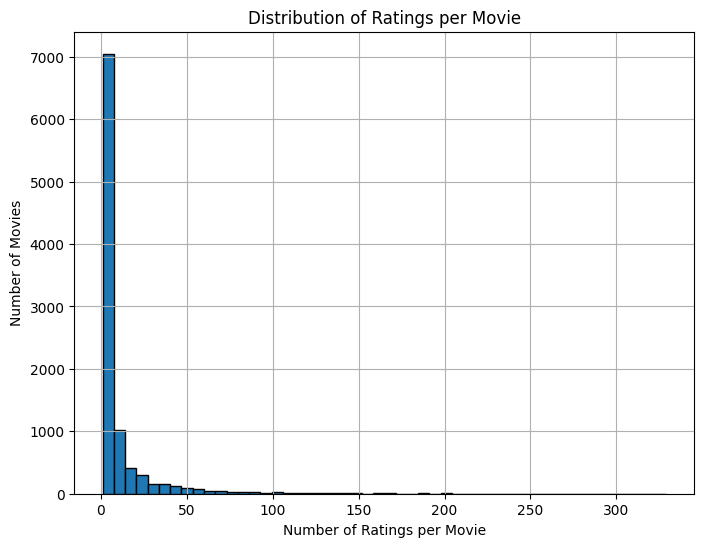

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
movie_ratingCount['totalRatingCount'].hist(bins=50)
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings per Movie')
plt.show()

## This code will generate a histogram showing the distribution of ratings for movies similar to “Guardians of the Galaxy (2014)”. You can adjust the visualization as needed to suit your specific requirements. Please make sure to have the necessary libraries installed and the data files in your working directory. Let me know if you need further assistance!